In [ ]:
input_folder = None
params_file = None
audiomentations_file = None

In [1]:
# imports
import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import librosa # for audio files
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain

### Manage and manipulate parameter inputs

- `num_seconds` is how long each chunk you will predict on is
- `sr_all` is the sampling rate of the audio file
    - up- or down-sample so that all audio files have this rate
- The other parameters come from `librosa.feature.melspectrogram`

In [ ]:
# for using papermill to run on terminal
# i.e., papermill -p input_folder [yours] -p params_file [yours] -p audiomentations_file [yours] tensorize-birds.ipynb [yours]
# process data in json file
with open(params_file) as f:
    params = json.load(f)
num_seconds = float(params['num_seconds'])
n_mels = int(params['n_mels'])
sr_all = int(params['sr_all'])
n_fft = int(params['n_fft'])
hop_length = int(params['hop_length'])
fmin = float(params['fmin'])
fmax = float(params['fmax'])
suffix = str(params['suffix'])
num_per_file = int(params['num_per_file'])

In [4]:
# manipulate the data for intermediate variables
window_size = int(num_seconds * sr_all)

# store arrays in same folder as audio files
output_folder = input_folder

def pad_to_multiple_of(array, factor):
    # Calculate the target size, which is the smallest multiple of the factor that is larger than or equal to the array size
    array = np.array(array)
    target_size = (array.shape[0] + factor - 1) // factor * factor
    
    # Calculate the padding size
    padding_size = target_size - array.shape[0]
    
    if padding_size > 0:
        # Pad the array with zeros
        padded_array = np.pad(array, (0, padding_size), mode='constant')
    else:
        padded_array = array
    
    return padded_array

In [ ]:
# Find all subfolders (bird species) in the main train_audio directory
bird_folders = [os.path.join(input_folder, d) for d in os.listdir(input_folder)
                if os.path.isdir(os.path.join(input_folder, d))]
bird_folders = sorted(bird_folders)
bird_names = [os.path.basename(d) for d in bird_folders]
bird_names = [d for d in bird_names if (d.find('.') <= -1)]
bird_names = np.unique(bird_names).tolist()
bird_names = sorted(bird_names)
birdname_to_label = {name: idx for idx, name in enumerate(bird_names)}
bird_names[:1]

['no_bird']

### Augment the sounds

In [ ]:
# for using papermill to run on terminal
# i.e., papermill -p input_folder [yours] -p params_file [yours] -p audiomentations_file [yours] tensorize-birds.ipynb [yours]
# process data in json file

with open(audiomentations_file) as f:
    params = json.load(f)

num_audiomentations = int(params['num_audiomentations'])
on_chunk = bool(params['on_chunk'])

# AddGaussianNoise()
min_amplitude_gaussian = float(params['min_amplitude_gaussian'])
max_amplitude_gaussian = float(params['max_amplitude_gaussian'])
p_gaussian = float(params['p_gaussian'])

# TimeStretch()
min_rate_timestretch = float(params['min_rate_timestretch'])
max_rate_timestretch = float(params['max_rate_timestretch'])
p_timestretch = float(params['p_timestretch'])

# PitchShift()
min_semitones_pitchshift = int(params['min_semitones_pitchshift'])
max_semitones_pitchshift = int(params['max_semitones_pitchshift'])
p_pitchshift = float(params['p_pitchshift'])

# Shift()
min_shift_shift = float(params['min_shift_shift'])
max_shift_shift = float(params['max_shift_shift'])
p_shift = float(params['p_shift'])

# Gain()
min_gain_db_gain = float(params['min_gain_db_gain'])
max_gain_db_gain = float(params['max_gain_db_gain'])
p_gain = float(params['p_gain'])


In [ ]:
# Define the augmentation pipeline

def augmenter(audio,
              sr,
              min_amplitude_gaussian,
              max_amplitude_gaussian,
              p_gaussian,
              min_rate_timestretch,
              max_rate_timestretch,
              p_timestretch,
              min_semitones_pitchshift,
              max_semitones_pitchshift,
              p_pitchshift,
              min_shift_shift,
              max_shift_shift,
              p_shift,
              min_gain_in_db_gain,
              max_gain_in_db_gain,
              p_gain,
             ):
    
    augment = Compose([
        
        # Add light ambient Gaussian noise with a 50% probability
        # min_amplitude=0.001 (very quiet) to max_amplitude=0.01 (noticeable but usually not overwhelming)
        AddGaussianNoise(min_amplitude=min_amplitude_gaussian, 
                         max_amplitude=max_amplitude_gaussian, 
                         p=p_gaussian),
    
        # Stretch the duration of the sound slightly (speed up or slow down) with 20% probability
        # rate 0.8 (slower) to 1.25 (faster)
        TimeStretch(min_rate=min_rate_timestretch, 
                    max_rate=max_rate_timestretch, 
                    p=p_timestretch),
    
        # Shift the pitch slightly up or down by a few semi-tones with 60% probability
        # -4 semi-tones to +4 semi-tones
        PitchShift(min_semitones=min_semitones_pitchshift, 
                   max_semitones=max_semitones_pitchshift, 
                   p=p_pitchshift),
    
        # Shift the time axis of the sound slightly with 70% probability
        # shift_ms can be positive or negative (forwards or backwards in time within the clip)
        Shift(min_shift=min_shift_shift, 
              max_shift=max_shift_shift, 
              p=p_shift),
        
        # Adjust the volume (gain) up or down slightly with 40% probability
        # min_gain_in_db=-6 (quieter) to max_gain_in_db=6 (louder)
        Gain(min_gain_db=min_gain_db_gain, 
             max_gain_db=max_gain_db_gain, 
             p=p_gain), 
        
    ])

    return augment(samples=audio, sample_rate=sr)

### Compute Mel spectrograms

In [ ]:
start_time = time.time()
curr_time = time.time()

Y = []
X = []
Z = []
A = []
B = []

itr = 1
ctr = 0

for bird_folder in bird_folders:

    # get audio files of the bird
    bird_name = os.path.basename(bird_folder)
    files = [f for f in os.listdir(bird_folder) if f.endswith('.ogg') 
             or f.endswith('.m4a') 
             or f.endswith('.wav') 
             or f.endswith('.flac') 
             or f.endswith('.mp3')
            ]
    files = sorted(files)

    for file in files:

        file_path = os.path.join(bird_folder, file)

        # load and process the file here
        audio, sr = librosa.load(file_path, sr=sr_all)
        audio = pad_to_multiple_of(audio, window_size)

        # Calculate the number of samples per chunk and the number of chunks
        num_chunks = int(np.ceil(len(audio) / window_size))
    
        # Get feature data for each chunk
        for i in range(num_chunks):
            start = i * window_size
            end = (i + 1) * window_size
            chunk = audio[start:end]
            # Compute the Mel spectrogram for the chunk
            melspec = librosa.feature.melspectrogram(y=chunk, 
                                                     sr=sr_all, 
                                                     n_fft=n_fft, 
                                                     hop_length=hop_length, 
                                                     n_mels=n_mels,
                                                     fmin=fmin,
                                                     fmax=fmax,
                                                    )
            melspec = librosa.power_to_db(melspec, ref=np.max, amin=np.finfo(float).eps)
            # store the data in big arrays/lists
            ctr += 1
            X.append(melspec)
            Y.append(birdname_to_label[bird_name])
            Z.append(file_path)
            A.append(start)
            B.append(end)
            if ctr >= num_per_file:
                # Save data as tensors
                Y = np.array(Y, dtype=np.float16)
                X = np.array(X, dtype=np.float16)
                # mel spectrograms
                np.save(output_folder + f'/X{suffix}_{itr*num_per_file}.npy', X)
                # labels
                np.save(output_folder + f'/Y{suffix}_{itr*num_per_file}.npy', Y)
                # where the files came from
                with open(output_folder + f"/files{suffix}_{itr*num_per_file}.csv","w") as f:
                    for _ in zip(Z, A, B):
                        f.write(f"{_[0]},{_[1]},{_[2]}\n")
                itr += 1
                # reset
                Y = []
                X = []
                Z = []
                A = []
                B = []
                ctr = 0

        for n in range(num_audiomentations):

            # augment
            if not on_chunk:
                audio2 = augmenter(audio, 
                                sr_all,
                                min_amplitude_gaussian,
                                max_amplitude_gaussian,
                                p_gaussian,
                                min_rate_timestretch,
                                max_rate_timestretch,
                                p_timestretch,
                                min_semitones_pitchshift,
                                max_semitones_pitchshift,
                                p_pitchshift,
                                min_shift_shift,
                                max_shift_shift,
                                p_shift,
                                min_gain_db_gain,
                                max_gain_db_gain,
                                p_gain,
                                )
            
            # Get feature data for each chunk
            for i in range(num_chunks):
                start = i * window_size
                end = (i + 1) * window_size
                if on_chunk:
                    chunk = augmenter(audio[start:end],
                                        sr_all,
                                        min_amplitude_gaussian,
                                        max_amplitude_gaussian,
                                        p_gaussian,
                                        min_rate_timestretch,
                                        max_rate_timestretch,
                                        p_timestretch,
                                        min_semitones_pitchshift,
                                        max_semitones_pitchshift,
                                        p_pitchshift,
                                        min_shift_shift,
                                        max_shift_shift,
                                        p_shift,
                                        min_gain_db_gain,
                                        max_gain_db_gain,
                                        p_gain,
                                      )
                else:
                    chunk = audio2[start:end]
                # Compute the Mel spectrogram for the chunk
                melspec = librosa.feature.melspectrogram(y=chunk, 
                                                         sr=sr_all, 
                                                         n_fft=n_fft, 
                                                         hop_length=hop_length, 
                                                         n_mels=n_mels,
                                                         fmin=fmin,
                                                         fmax=fmax,
                                                        )
                melspec = librosa.power_to_db(melspec, ref=np.max, amin=np.finfo(float).eps)
                # store the data in big arrays/lists
                ctr += 1
                X.append(melspec)
                Y.append(birdname_to_label[bird_name])
                Z.append(file_path)
                A.append(start)
                B.append(end)
                if ctr >= num_per_file:
                    # Save data as tensors
                    Y = np.array(Y, dtype=np.float16)
                    X = np.array(X, dtype=np.float16)
                    # mel spectrograms
                    np.save(output_folder + f'/X{suffix}_{itr*num_per_file}.npy', X)
                    # labels
                    np.save(output_folder + f'/Y{suffix}_{itr*num_per_file}.npy', Y)
                    # where the files came from
                    with open(output_folder + f"/files{suffix}_{itr*num_per_file}.csv","w") as f:
                        for _ in zip(Z, A, B):
                            f.write(f"{_[0]},{_[1]},{_[2]}\n")
                    itr += 1
                    # reset
                    Y = []
                    X = []
                    Z = []
                    A = []
                    B = []
                    ctr = 0
            

    next_time = time.time()
    print(f'Bird {bird_name} processed in {next_time - curr_time} seconds.')
    print()
    curr_time = next_time

end_time = time.time()
print('----------')
print(f'All birds processed in {end_time - start_time} seconds.')

Bird eucdov processed in 1.4061415195465088 seconds.

Bird whtkin2 processed in 0.7556405067443848 seconds.

Bird tafpri1 processed in 0.652820348739624 seconds.

Bird fotdro5 processed in 1.1316182613372803 seconds.

Bird ratcis1 processed in 0.88700270652771 seconds.

Bird saffin processed in 1.475698471069336 seconds.

Bird comior1 processed in 1.1465978622436523 seconds.

Bird carcha1 processed in 1.0427556037902832 seconds.

Bird perfal processed in 1.9953675270080566 seconds.

Bird purher1 processed in 0.5444009304046631 seconds.

----------
All birds processed in 11.039242029190063 seconds.


### A single visualization

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

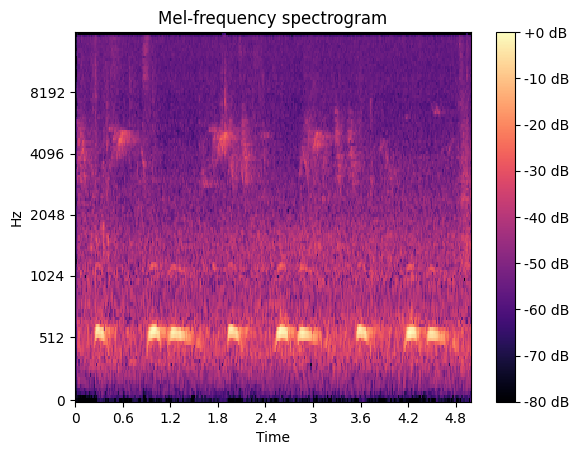

In [ ]:
# visualize an example
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(X, ref=np.max, amin=np.finfo(float).eps)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr_all,
                         fmax=fmax, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

### Saving the data

- `X.npy` is spectrograms per some number of seconds
- `Y.npy` is the class label of the bird
- `files.csv` is the name of the file where spectrogram came from
- `birds.csv` is the dictionary mapping of bird to label

Note that there are suffixes for the case of multiple runs and saving fies intermittently.